# Exercise M2.01

The aim of this exercise is to make the following experiments:

* train and test a support vector machine classifier through cross-validation;
* study the effect of the parameter gamma of this classifier using a validation curve;
* use a learning curve to determine the usefulness of adding new samples in the data set when building a classifier.

In [54]:
import pandas as pd
import numpy as np
# Disable jedi autocompleter
%config Completer.use_jedi = False

In [55]:
df = pd.read_csv('data/blood_transfusion.csv')
df.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,donated
1,0,13,3250,28,donated
2,1,16,4000,35,donated
3,2,20,5000,45,donated
4,1,24,6000,77,not donated


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Recency    748 non-null    int64 
 1   Frequency  748 non-null    int64 
 2   Monetary   748 non-null    int64 
 3   Time       748 non-null    int64 
 4   Class      748 non-null    object
dtypes: int64(4), object(1)
memory usage: 29.3+ KB


In [57]:
target = df['Class']
data = df.drop(columns='Class')

We will use a support vector machine classifier (SVM). In its most simple form, a SVM classifier behaving similarly to a logistic regression. 

Also the classifier can become more flexible/expressive by using a so-called kernel that makes the model become non-linear. We will use an RBF kernel where a parameter `gamma` allows to tune the flexibility of the model.

First let's create a predictive pipeline made of:

* a `sklearn.preprocessing.StandardScaler` with default parameter
* a `sklearn.svm.SVC` where the parameter `kernel` could be set to  `rbf`. Note that this is the default.

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [59]:
model = make_pipeline(StandardScaler(), SVC())

Evaluate the generalization performance of our model by cross-validation with a `ShuffleSplit` scheme. Thus, you can use `sklearn.model_selection.cross_validate` and pass a `sklearn.model_selection.ShuffleSplit` to the `cv` parameter. Only fix the `random_state=0` in the `ShuffleSplit` and let the other parameters to the default.


In [60]:
from sklearn.model_selection import ShuffleSplit
res = cross_validate(model, data, target, cv=ShuffleSplit(random_state=42))

In [61]:
print(f"Accuracy score: {res['test_score'].mean():.3f} +/- {res['test_score'].std():.3f}")

Accuracy score: 0.787 +/- 0.043


As previously mentioned, the parameter `gamma` is one of the parameters controlling under/over-fitting in support vector machine with an RBF kernel.

Evaluate the effect of the parameter `gamma` by using `sklearn.model_selection.validation_curve` function. You can leave the default `scoring=None` which is equivalent to `scoring="accuracy"` for classification problems. You can vary `gamma` between `10e-3` and `10e2` by generating samples on a logarithmic scale with the help of `np.logspace(-3, 2, num=30)`.

Since we are manipulating a `Pipeline` the parameter name will be set to `svc_gamma` instead of only `gamma`. You can retrieve the parameter name using `model.get_params().keys()`.


In [62]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [63]:
from sklearn.model_selection import validation_curve
gammas = np.logspace(-3, 2, num=30)
cv = ShuffleSplit(random_state=0)
train_scores, test_scores = validation_curve(
    model, data, target, param_name="svc__gamma", param_range=gammas,
    cv=cv,  n_jobs=2
)

Plot the validation curve for the train and test scores.

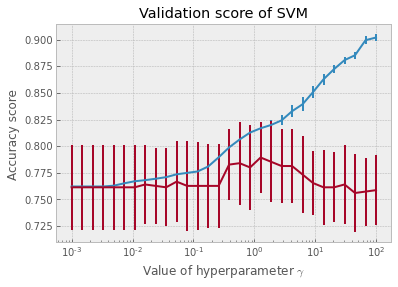

In [64]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.errorbar(gammas, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(gammas, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Test score")
plt.xscale("log")
plt.xlabel(r"Value of hyperparameter $\gamma$")
plt.ylabel("Accuracy score ")
plt.title("Validation score of SVM");

Looking at the curve we can clearly identify the over-fitting regime of the SVC classifier when `gamma > 1`. The best setting is around `gamma=1`, while for `gamma < 1`, it is not very clear if the classifier is under-fitting but the testing score is worse than for `gamma = 1`.

Now, we can perform an analysis to check whether adding new samples to the dataset could help our model to better generalize. Compute the learning curve (using `sklearn.model_selection.learning_curve`) by computing the train and test scores for different training dataset size. Plot the train and test scores with respect to the number of samples.

In [65]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1.0, num=10, endpoint=True)
res = learning_curve(
    model, data, target, train_sizes=train_sizes,
    cv=cv, n_jobs=2
)
train_size, train_scores, test_scores = res[:3]

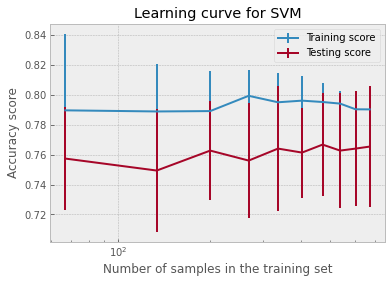

In [66]:
plt.errorbar(train_size, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(train_size, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xscale("log")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy score")
plt.title("Learning curve for SVM");

We observe that adding new samples in the dataset does not improve the testing score. We can only conclude that the standard deviation of the training error is decreasing when adding more samples which is not a surprise.